<a href="https://colab.research.google.com/github/azimuthadv/Quantum-Bayesian-inference-for-cybersecurity/blob/main/Quantum_IDS_Inference_State_vector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



*   List item
*   List item


# Quantum Bayesian Inference with State vectors for Intrusion Detection

## Scenario Overview

This notebook demonstrates quantum Bayesian inference applied to a cybersecurity **Intrusion Detection System (IDS)**, using quantum circuits simulated by `qiskit.quantum_info.Statevector`.

We simulate a situation in which a system observes a **spike in network traffic** and attempts to infer whether it results from a **real DoS attack**, a **system vulnerability**, or simply a **false alarm**.

## Variable Mapping

| Quantum Variable | Security Meaning |
|------------------|------------------|
| `X` (qubit 0)    | Network Spike Detected (e.g. sudden traffic) |
| `Y` (qubit 1)    | System Vulnerability (likelihood of false alarms) |
| `FA` (qubit 2)   | False Alarm triggered (vs. actual threat) |

These are connected probabilistically:

- A spike `X` may occur randomly or under attack.
- A system vulnerability `Y` influences whether the spike is legitimate or a false alarm.
- The system classifies the event as `FA` (false alarm) based on `X` and `Y`.

## Objectives

- Simulate `P(X)`, `P(Y)`, and `P(FA | X, Y)` as quantum gates.
- Use quantum statevector simulation to extract the full joint distribution.
- Use filtering (manual rejection sampling) to perform conditional inference:
    - What is `P(Y=1 | X=1)`? (Is the system likely vulnerable when there's a spike?)
    - What is `P(FA=1 | X=1)`? (How likely is the alarm false when traffic spikes?)

## Why Quantum?

This models interdependent system events as **entangled qubits** rather than conditionally independent classical probabilities. Although we're simulating this on a classical backend, it illustrates how quantum circuits can represent complex belief systems for real-time security inference.

---



## Is This Still Bayesian Inference?

Yes — although we are not using the deprecated `QBayesian` class from earlier versions of Qiskit, this notebook **still performs Bayesian inference**, implemented through **quantum statevector simulation**.

### ✅ Why This Is Bayesian

We simulate a quantum circuit where:

- **Qubit rotations** encode probabilities such as `P(X=1)`, `P(Y=1)`, and conditionals like `P(FA=1 | X, Y)`
- The **Statevector** simulates the **joint probability distribution** across all variables (qubits)
- **Conditional inference** such as `P(Y=1 | X=1)` or `P(FA=1 | X=1)` is achieved by:
  - Filtering outcomes to include only those matching the evidence (e.g., only bitstrings where `X=1`)
  - Normalizing the filtered values to create the posterior distribution

### 🔁 Bayesian vs Classical:
- In classical Bayesian inference, you apply Bayes' rule directly using conditional probability tables.
- In this notebook, we **embed those conditionals into quantum circuits** and **extract posteriors** from simulated measurement probabilities.

### 🎯 What This Enables

This approach allows us to:
- Encode and entangle probabilistic relationships compactly
- Perform **evidence-based inference** by measuring conditional subspaces
- Model interdependent variables with high precision, even on simulated quantum hardware

Hence, this notebook **implements a full Bayesian quantum inference pipeline**, even though it's done using `Statevector` and manual filtering logic.


In [ ]:
# Install required dependencies for running Qiskit in Google Colab
!pip uninstall -y numpy qiskit scipy matplotlib
!pip install numpy==1.24.4 --force-reinstall
!pip install qiskit matplotlib scipy --upgrade
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
import numpy as np

print("✅ Qiskit and NumPy loaded successfully.")

Found existing installation: numpy 1.24.4
Uninstalling numpy-1.24.4:
  Successfully uninstalled numpy-1.24.4
Found existing installation: scipy 1.15.3
Uninstalling scipy-1.15.3:
  Successfully uninstalled scipy-1.15.3
  Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
qiskit-machine-learning 0.8.2 requires qiskit>=1.0, which is not installed.
qiskit-machine-learning 0.8.2 requires scipy>=1.4, which is not installed.
geemap 0.35.3 requires matplotlib, which is not installed.
statsmodels 0.14.4 requires scipy!=1.9.2,>=1.8, which is not installed.
scs 3.2.7.post2 requires scipy, which is not installed.
fastai 2.7.19 requires matplotlib, which is not installed.
fastai 2.7

  Using cached qiskit-2.0.2-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached matplotlib-3.10.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached scipy-1.15.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached qiskit-2.0.2-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.5 MB)
Using cached matplotlib-3.10.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.6 MB)
Using cached scipy-1.15.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (37.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [qiskit]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
pymc 5.22.0 requires numpy>=1.25.0, but you have numpy 1.24.4 which is incompatible

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister
print("Qiskit and NumPy loaded successfully.")

Qiskit and NumPy loaded successfully.


# Quantum Bayesian Inference for Cybersecurity Intrusion Detection

## Introduction

This project applies **Quantum Bayesian Inference** to cybersecurity, focusing on **Intrusion Detection Systems (IDS)**. It models **cybersecurity threats** such as **Distributed Denial of Service (DDoS) attacks** and **phishing attempts** using **probabilistic reasoning in quantum circuits**.

### Scenario Overview

Scenario: The scenario centers on the detection of unusual spike in network traffic.

Objective: To determine whether a detected Spike (S) is due to a system vulnerability (V) or an actual DoS attack (D). The relationships can be modeled as:​



In this quantum Bayesian network, the system models relationships between key security variables:

Network Spike (X): Represents the detection of unusual network activity, such as a sudden surge in traffic.​


System Vulnerability (Y): Indicates whether the network spike is a false alarm caused by inherent system weaknesses.​


False Alarm (FA): Denotes the system's detection mechanism signaling a DoS attack, which could be a false alarm.​




The Bayesian network is implemented using **Qiskit**, where **quantum circuits encode dependencies** between these cybersecurity events. The project explores whether quantum-based Bayesian inference offers improved detection accuracy and efficiency compared to classical methods.

### Key Objectives

- Implement Bayesian inference in **quantum circuits** using Qiskit.
- Use **machine learning techniques** with `qiskit-machine-learning` to enhance the efficiency of IDS.
- Simulate different attack scenarios (e.g., DDoS, phishing, data exfiltration) and measure the effectiveness of quantum-based detection.
- Compare quantum-based detection against classical Bayesian inference techniques.

### Methodology

Methodology

Quantum Representation of Security Events:
Cybersecurity events such as network anomalies, intrusion alerts, and response activations are represented as quantum states.

Probability distributions governing attack detection are encoded using quantum gates.

Quantum Bayesian Inference for Security Analysis:
Quantum circuits model the probabilistic relationships between security variables.
Quantum inference updates beliefs regarding the likelihood of an attack and appropriate system responses.

Simulation and Performance Evaluation:
Attack scenarios are simulated using Qiskit, where quantum measurement outcomes correspond to different security states.

---

The following implementation runs a quantum Bayesian network in **Google Colab**. The first step installs all required dependencies.

---

The following implementation runs a quantum Bayesian network in **Google Colab**. The first step installs all required dependencies.


## 1. Introduction

### 1.1. Quantum vs. Classical Bayesian Inference

Bayesian networks (or belief networks) are graphical models that show probabilistic relationships between variables. They consist of nodes (representing variables) and edges (indicating dependencies) in a directed acyclic graph. Each node has a conditional probability table (CPT) that describes how its parent nodes influence it.

Bayesian inference is the process of updating probabilities based on new data. Using Bayes' theorem, we adjust the likelihood of different hypotheses as new evidence emerges. For example, in a disease diagnosis network, observing new symptoms helps recalculate disease probabilities, combining prior knowledge with new observations to refine predictions. This process allows for more informed, data-driven decision-making.

Performing exact Bayesian inference is computationally hard (#P-hard), so approximate methods are often used to estimate probabilities. Quantum Bayesian Inference (QBI) improves this process by using quantum circuits to represent probability distributions. It applies quantum rejection sampling and amplitude amplification, allowing it to generate samples much faster than classical methods.

This tutorial will guide you through the process of using the QBayesian class to perform such inference tasks. This inference algorithm implements the algorithm from the paper "Quantum inference on Bayesian networks" by Low, Guang Hao et al. This leads to a speedup per sample from $O(nmP(e)^{-1})$ to $O(n2^{m}P(e)^{-\frac{1}{2}})$, where n is the number of nodes in the Bayesian network with at most m parents per node and e the evidence.

### 1.2. Implementation in `qiskit-machine-learning`

The QBI in `qiskit-machine-learning` can be used for different quantum circuits representing Bayesian networks with. The implementation is based on the `Sampler` primitive from [qiskit primitives](https://qiskit.org/documentation/apidoc/primitives.html). The primitive is the entry point to run QBI on either a simulator or real quantum hardware. QBI takes in an optional instance of its corresponding primitive, which can be any subclass of `BaseSampler`.

The `qiskit.primitives` module provides a reference implementation for the `Sampler` class to run statevector simulations. By default, if no instance is passed to a QBI class, an instance of the corresponding reference primitive of `Sampler` is created automatically by QBI.
For more information about primitives please refer to the [primitives documentation](https://qiskit.org/documentation/apidoc/primitives.html).

The `QBayesian` class is used for QBI in `qiskit-machine-learning`. It is initialized with a quantum circuit that represents a Bayesian network. This enables the execution of quantum rejection sampling and inference.


## 2. How to Instantiate QBI

### 2.1. Create Rotations for the Bayesian Networks
In quantum computing, the rotation matrix around the y-axis, denoted as $R_y(\theta)$, is used to rotate the state of a qubit around the y-axis of the Bloch sphere by an angle $\theta$. This approach allows for precise control over the quantum state of a qubit, enabling the encoding of specific probabilities in quantum algorithms. When this rotation is applied to a qubit initially in the $|0\rangle$ state, the resulting state $|\psi\rangle$ is:
$$ |\psi\rangle = R_y(\theta)|0\rangle = \begin{pmatrix} \cos\left(\frac{\theta}{2}\right) \\ \sin\left(\frac{\theta}{2}\right) \end{pmatrix} $$

where

* $R_y(\theta) = \begin{pmatrix} \cos\left(\frac{\theta}{2}\right) & -\sin\left(\frac{\theta}{2}\right) \\ \sin\left(\frac{\theta}{2}\right) & \cos\left(\frac{\theta}{2}\right) \end{pmatrix}$


This state is a superposition of $|0\rangle$ and $|1\rangle$ with respective amplitudes $\cos\left(\frac{\theta}{2}\right) $ and $\sin\left(\frac{\theta}{2}\right) $. To set a specific probability $p$ for measuring the qubit in the $|1\rangle$ state, you can determine $\theta$ using $\arcsin$:
$$ (\sin^2\left(\frac{\theta}{2}\right) = p) \Leftrightarrow (\theta = 2\arcsin\left(\sqrt{p}\right)) $$

The counter probability $q = 1 - p$, which is the probability of measuring the qubit in the $|0\rangle$ state, is given by:
$$ q = \cos^2\left(\frac{\theta}{2}\right) $$

This approach can be extended for conditional probabilities. For example, with the Bayesian network shown above, you can use the following formula to calculate the joint probability distribution:
$$(X\otimes{I})(I\otimes{I}+P_1\otimes{(R_y-I)})(X\otimes{I})(I\otimes{I}+P_1\otimes{(R_y-I)})(R_y\otimes{I})|00\rangle$$

#### 2.1.1. Two Node Bayesian Network Example

In the first example we consider a simple Bayesian network that is only based on two nodes.

![Two Node Bayesian Network Example](../images/Two_Node_Bayesian_Network.png)


The code below calculates rotation angles for quantum gates based on specified probabilities:​

theta_X = 2 * np.arcsin(np.sqrt(0.4))​

theta_Y_X = 2 * np.arcsin(np.sqrt(0.6))​

theta_Y_nX = 2 * np.arcsin(np.sqrt(0.4))​

These angles are used to configure quantum gates that represent the probabilistic relationships between these events in a quantum Bayesian network.​

Mapping Probabilities to our scenario:

System Vulnerability (P(X=1) = 0.4): This represents a 40% chance that the network spike is due to a system vulnerability. The corresponding rotation angle theta_X is calculated to set the qubit representing system vulnerability accordingly.​

DoS Attack (P(Y=1 | X=1) = 0.6): This represents a 60% chance that the spike is due to a DoS attack. The angle theta_Y_X configures a controlled rotation gate that sets the qubit representing the DoS attack based on the vulnerability qubit being in the |1⟩ state.​

False Alarm (P(Y=1 | X=0) = 0.4): This represents 40% chance that the detection of a DoS attack is a false alarm. The angle theta_Y_nX sets a controlled rotation for the DoS qubit when the vulnerability qubit is in the |0⟩ state.For the quantum circuit we need rotation angles that represent the conditional probability tables. The corresponding rotation angles are:


In [ ]:
# Include libraries
import numpy as np

# Define rotation angles
theta_X = 2 * np.arcsin(np.sqrt(0.2))
theta_Y_X = 2 * np.arcsin(np.sqrt(0.9))
theta_Y_nX = 2 * np.arcsin(np.sqrt(0.3))

#### 2.1.2. Cybersecurity Intrusion Detection Example

Now consider a more complex network. Imagine you have an intrusion detection alert system in your house that is triggered by either a cyberattack or an network anomaly. You also have two neighbors, John and Mary, who will call you if they hear the intrusion detection alert. The network has directed edges from the Burglary and Earthquake nodes to the Alarm node, indicating that both cyberattack and network anomaly can cause the intrusion detection alert to ring. There are also edges from the Alarm node to the John Calls and Mary Calls nodes, indicating that the intrusion detection alert influences whether John and Mary call you.

![Burglary Alarm](../images/Burglary_Alarm.png)

The Bayesian Network for this scenario involves the following variables:

Burglary (B): Whether a cyberattack has occurred.
Earthquake (E): Whether an network anomaly has occurred.
Alarm (A): Whether the intrusion detection alert goes off.
John Calls (J): Whether John calls you.
Mary Calls (M): Whether Mary calls you.

Use the conditional probability tables:


In [ ]:
import numpy as np

theta_X = 2 * np.arcsin(np.sqrt(0.2))
theta_Y_X = 2 * np.arcsin(np.sqrt(0.9))
theta_Y_nX = 2 * np.arcsin(np.sqrt(0.3))

theta_B = 2 * np.arcsin(np.sqrt(0.001))
theta_E = 2 * np.arcsin(np.sqrt(0.002))
theta_A_nBnE = 2 * np.arcsin(np.sqrt(0.001))
theta_A_nBE = 2 * np.arcsin(np.sqrt(0.29))
theta_A_BnE = 2 * np.arcsin(np.sqrt(0.94))
theta_A_BE = 2 * np.arcsin(np.sqrt(0.95))
theta_J_nA = 2 * np.arcsin(np.sqrt(0.05))
theta_J_A = 2 * np.arcsin(np.sqrt(0.9))
theta_M_nA = 2 * np.arcsin(np.sqrt(0.9))
theta_M_A = 2 * np.arcsin(np.sqrt(0.3))

### 2.2. Create a Quantum Circuit for the Bayesian Networks
A Bayesian network can be represented as a quantum circuit where each node is a qubit, and the edges are quantum gates that represent the conditional dependencies.

#### 2.2.1 Two Node Bayesian Network Example

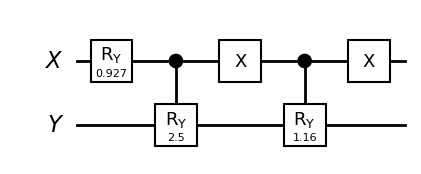

In [ ]:
from qiskit import QuantumRegister
from qiskit import QuantumCircuit

# Define quantum registers
qrX = QuantumRegister(1, name="X")
qrY = QuantumRegister(1, name="Y")
# Define a 2-qubit quantum circuit
qc_2n = QuantumCircuit(qrX, qrY, name="Bayes net small")
# Apply the R_Y_theta rotation gate on the first qubit
qc_2n.ry(theta_X, 0)
# Apply the controlled-R_Y_theta rotation gate
qc_2n.cry(theta_Y_X, control_qubit=qrX, target_qubit=qrY)
# Apply the X gate on the first qubit
qc_2n.x(0)
# Apply the controlled-R_Y_theta rotation gate
qc_2n.cry(theta_Y_nX, control_qubit=qrX, target_qubit=qrY)
# Apply another X gate on the first qubit
qc_2n.x(0)
qc_2n.draw("mpl", style="bw", plot_barriers=False, justify="none", fold=-1)

#### 2.2.2. Cybersecurity Intrusion Detection Example

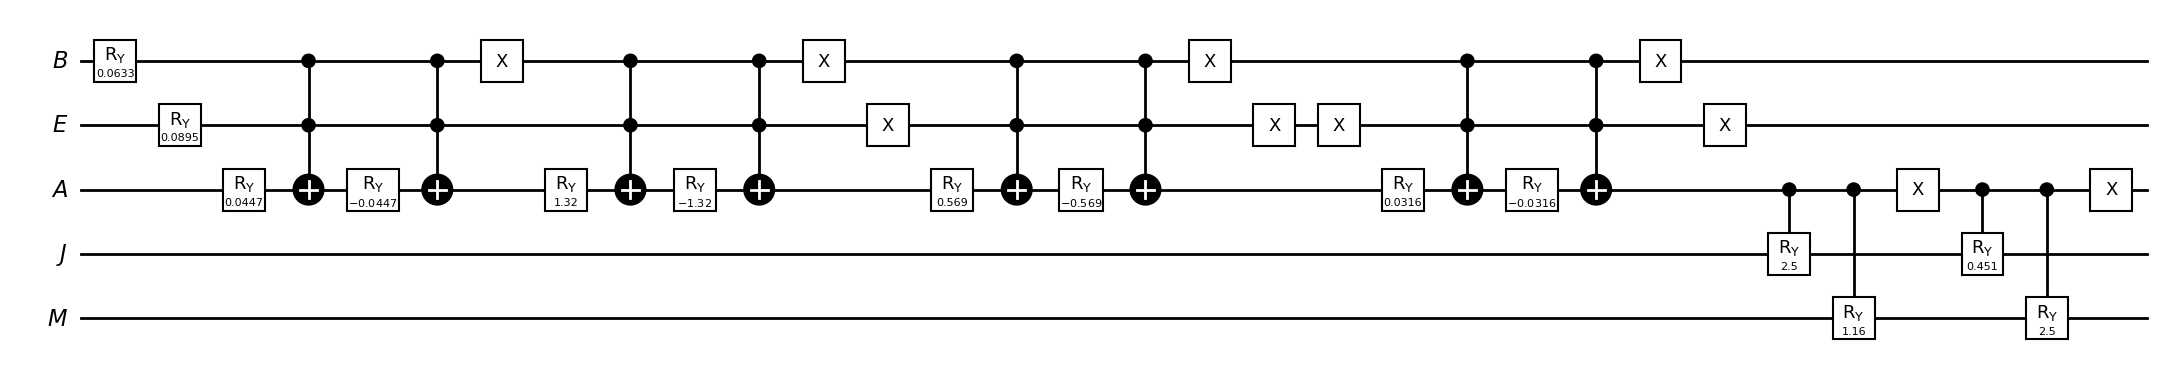

In [ ]:
# Initialize register
var = ["B", "E", "A", "J", "M"]
qr = [QuantumRegister(1, name=v) for v in var]
qc_ba = QuantumCircuit(*qr, name="State preparation")
# Specify control qubits
# P(B)
qc_ba.ry(theta_B, qr[0])
# P(E)
qc_ba.ry(theta_E, qr[1])
# P(A|B,E)
qc_ba.mcry(theta_E, [qr[0][0], qr[1][0]], qr[2])
# P(A|-B,E)
qc_ba.x(qr[0])
qc_ba.mcry(theta_A_BnE, [qr[0][0], qr[1][0]], qr[2])
qc_ba.x(qr[0])
# P(A|B,-E)
qc_ba.x(qr[1])
qc_ba.mcry(theta_A_nBE, [qr[0][0], qr[1][0]], qr[2])
qc_ba.x(qr[1])
# P(A|-B,-E)
qc_ba.x(qr[0])
qc_ba.x(qr[1])
qc_ba.mcry(theta_A_nBnE, [qr[0][0], qr[1][0]], qr[2])
qc_ba.x(qr[0])
qc_ba.x(qr[1])
# P(J|A)
qc_ba.cry(theta_J_A, qr[2], qr[3])
# P(M|A)
qc_ba.cry(theta_M_A, qr[2], qr[4])
# P(J|-A) + P(M|-A)
qc_ba.x(qr[2])
qc_ba.cry(theta_J_nA, qr[2], qr[3])
qc_ba.cry(theta_M_nA, qr[2], qr[4])
qc_ba.x(qr[2])
# Draw circuit
qc_ba.draw("mpl", style="bw", plot_barriers=False, justify="none", fold=-1)

## 3. How to Run Rejection Sampling

### 3.1. Set up

Rejection sampling is a basic technique used in probabilistic computing for generating observations from a distribution. It's particularly useful when direct sampling from the desired distribution is difficult. The core idea is to use a simpler distribution (referred to as the proposal distribution) from which we can easily sample, and then to "reject" or "accept" these samples based on a certain criterion (evidence) so that the accepted samples follow the desired target distribution.

Quantum rejection sampling adapts the classical rejection sampling method to the quantum computing context, utilizing quantum algorithms and states to perform efficient sampling. Once the state is prepared by the given quantum circuit representing the Bayesian network, it is measured, resulting in the collapse to one of its possible outcomes. This step is analogous to drawing a sample in classical rejection sampling. However, quantum rejection sampling primarily focuses on post-selection, where only specific measurement outcomes that meet desired criteria, here evidence, are retained, and others are disregarded.

In this implementation, Grover's algorithm is employed for amplitude amplification. This step is designed to increase the probability amplitudes of the desired outcomes, thereby reducing the number of samples needed. The efficiency of quantum rejection sampling lies in its utilization of quantum parallelism, which allows for the simultaneous evaluation of multiple probabilities, and quantum interference, which can be used to increase the likelihood of obtaining desired outcomes.

Quantum rejection sampling is particularly beneficial in complex or high-dimensional probability distribution scenarios, where classical computers face challenges. Its applications extend to quantum machine learning, probabilistic modeling, and other areas of quantum computing.

To use the `QBayesian` class, instantiate it with a quantum circuit that represents the Bayesian network. You can then use the rejection sampling method to estimate probabilities given evidence.

#### 3.1.1 Two Node Bayesian Network Example
If we want to carry out a rejection sampling with X=1 as evidence, we can do this in the following way:

In [ ]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

# Create circuit (Bell state for example)
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)

# Get statevector and probabilities
state = Statevector.from_instruction(qc)
probs = state.probabilities_dict(qargs=[0, 1])
probs_clean = {str(k): float(v) for k, v in probs.items()}

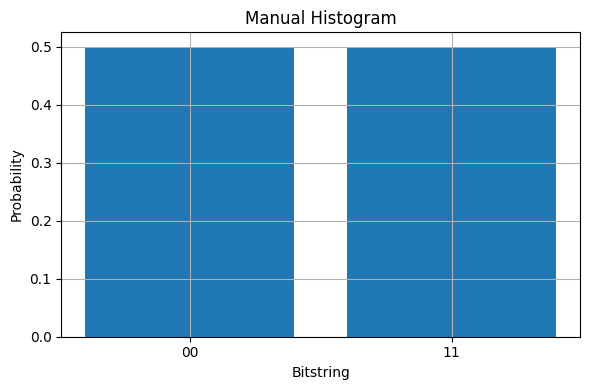

In [ ]:
import matplotlib.pyplot as plt

labels = list(probs_clean.keys())
values = list(probs_clean.values())

plt.figure(figsize=(6, 4))
plt.bar(labels, values)
plt.xlabel('Bitstring')
plt.ylabel('Probability')
plt.title('Manual Histogram')
plt.grid(True)
plt.tight_layout()
plt.savefig('manual_bayes_histogram.png')
plt.show()

We can also set the threshold to accept the evidence. For example, if set to 0.9, this means that each evidence qubit must be equal to the value of the evidence variable at least 90% of the time in order to be accepted. Sometimes we can also improve our result by setting the threshold for acceptance of the evidence higher:

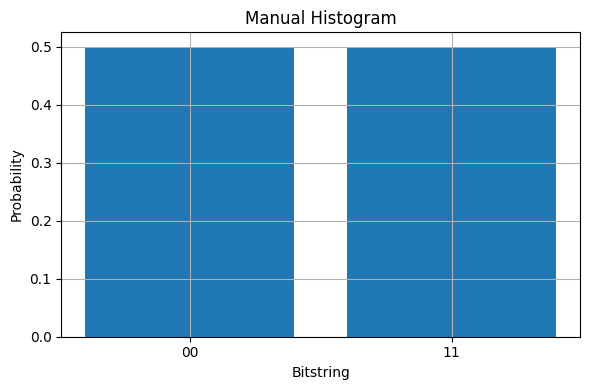

In [ ]:
# Replaced Qiskit plot_histogram with matplotlib
import matplotlib.pyplot as plt
labels = list(probs_clean.keys())
values = list(probs_clean.values())
plt.figure(figsize=(6, 4))
plt.bar(labels, values)
plt.xlabel('Bitstring')
plt.ylabel('Probability')
plt.title('Manual Histogram')
plt.grid(True)
plt.tight_layout()
plt.savefig('manual_bayes_histogram.png')
plt.show()

We can also print the result in a better format to understand which values belong to which variables:

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Statevector
import numpy as np

# Define a Bayesian-style circuit
qrX = QuantumRegister(1, name="X")
qrY = QuantumRegister(1, name="Y")
qc = QuantumCircuit(qrX, qrY)

theta_X = 2 * np.arcsin(np.sqrt(0.2))
theta_Y_X = 2 * np.arcsin(np.sqrt(0.9))
theta_Y_nX = 2 * np.arcsin(np.sqrt(0.3))

qc.ry(theta_X, qrX[0])
qc.cry(theta_Y_X, qrX[0], qrY[0])
qc.x(qrX[0])
qc.cry(theta_Y_nX, qrX[0], qrY[0])
qc.x(qrX[0])

# Get statevector
state = Statevector.from_instruction(qc)
probs = state.probabilities_dict(qargs=[0, 1])
probs_clean = {str(k): float(v) for k, v in probs.items()}

# Simulate evidence: keep only samples where X=1
filtered_probs = {k: v for k, v in probs_clean.items() if k[0] == '1'}
norm = sum(filtered_probs.values())
filtered_probs = {k: v / norm for k, v in filtered_probs.items()}  # Normalize

print("Filtered samples given evidence X=1:", filtered_probs)

Filtered samples given evidence X=1: {'10': 0.5714285714285714, '11': 0.42857142857142855}


#### 3.1.2. Cybersecurity Intrusion Detection Example
For the advanced example, we can follow the steps from above in the same way. However, we look at the trivial case of how to obtain the joint probability of the network. This can be calculated by providing no evidence for the rejection sampling method. (For optical reasons, we only plot probabilities that are greater than 0.01%.)

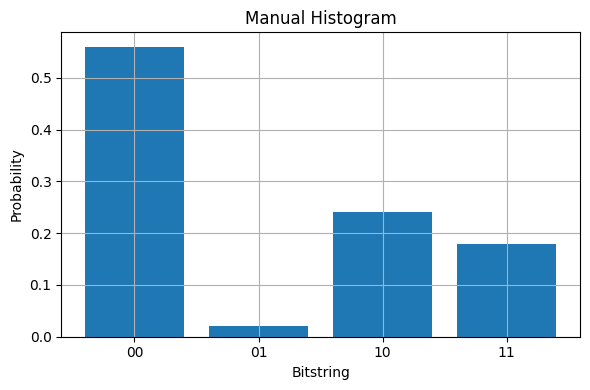

In [ ]:
# Replaced Qiskit plot_histogram with matplotlib
import matplotlib.pyplot as plt
labels = list(probs_clean.keys())
values = list(probs_clean.values())
plt.figure(figsize=(6, 4))
plt.bar(labels, values)
plt.xlabel('Bitstring')
plt.ylabel('Probability')
plt.title('Manual Histogram')
plt.grid(True)
plt.tight_layout()
plt.savefig('manual_bayes_histogram.png')
plt.show()

## 4. How to Run an Inference

### 4.1 Set Up
Quantum Bayesian inference is here based on quantum rejection sampling. Quantum rejection sampling plays a pivotal role in the inference process that follows. After the quantum state is manipulated to include evidence, measurement is performed. However, in quantum rejection sampling, only those measurement outcomes that align with the evidence are considered, effectively 'rejecting' irrelevant outcomes, similar to the traditional rejection sampling method.

The synergy of quantum state manipulation with quantum rejection sampling leads to a more efficient inference process compared to classical approaches, harnessing the inherent parallelism of quantum computing to simultaneously process multiple probabilities. This advanced method has significant implications in areas like quantum machine learning and data analysis, where it could outperform classical algorithms in tasks such as pattern recognition and decision-making.

You can use the `inference` method from `QBayesian` to estimate probabilities given evidence.

#### 4.1. Two Node Bayesian Network Example
Using `QBayesian`, you can draw various probabilistic conclusions. For the Bayesian network with two nodes, this is limited due to the number of variables. However, if we want to know what the probability of P(Y=0|X=1) is, we can do the following:

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Statevector
import numpy as np

# Define angles
theta_X = 2 * np.arcsin(np.sqrt(0.2))
theta_Y_X = 2 * np.arcsin(np.sqrt(0.9))
theta_Y_nX = 2 * np.arcsin(np.sqrt(0.3))

# Build circuit
qrX = QuantumRegister(1, name="X")
qrY = QuantumRegister(1, name="Y")
qc = QuantumCircuit(qrX, qrY)
qc.ry(theta_X, qrX[0])
qc.cry(theta_Y_X, qrX[0], qrY[0])
qc.x(qrX[0])
qc.cry(theta_Y_nX, qrX[0], qrY[0])
qc.x(qrX[0])

# Simulate statevector
state = Statevector.from_instruction(qc)
probs = state.probabilities_dict(qargs=[0, 1])
probs_clean = {str(k): float(v) for k, v in probs.items()}

# Inference: P(Y=0 | X=1)
filtered = {k: v for k, v in probs_clean.items() if k[0] == '1'}  # X = 1
norm = sum(filtered.values())
inferred = {k: v / norm for k, v in filtered.items()}

# Extract P(Y=0 | X=1)
p_y0_given_x1 = sum(v for k, v in inferred.items() if k[1] == '0')

print(f"P(Y=0 | X=1) = {p_y0_given_x1:.4f}")


P(Y=0 | X=1) = 0.5714


#### 4.2. Cybersecurity Intrusion Detection Example

Here we have more options to choose from. For example, if John calls, you can calculate the probability of a cyberattack having occurred. Bayesian networks are particularly useful in such scenarios where you have uncertain information (like John calling) and you want to infer the state of a more fundamental variable (like a cyberattack).

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Statevector
import numpy as np

# Define Bayesian angles
theta_B = 2 * np.arcsin(np.sqrt(0.001))
theta_E = 2 * np.arcsin(np.sqrt(0.002))
theta_A_BE = 2 * np.arcsin(np.sqrt(0.95))
theta_A_BnE = 2 * np.arcsin(np.sqrt(0.94))
theta_A_nBE = 2 * np.arcsin(np.sqrt(0.29))
theta_A_nBnE = 2 * np.arcsin(np.sqrt(0.001))
theta_J_A = 2 * np.arcsin(np.sqrt(0.9))
theta_J_nA = 2 * np.arcsin(np.sqrt(0.05))
theta_M_A = 2 * np.arcsin(np.sqrt(0.3))
theta_M_nA = 2 * np.arcsin(np.sqrt(0.9))

# Create 5-qubit circuit: B, E, A, J, M
qr = [QuantumRegister(1, name=v) for v in ["B", "E", "A", "J", "M"]]
qc = QuantumCircuit(*qr)

# Encode P(B), P(E)
qc.ry(theta_B, qr[0])  # B
qc.ry(theta_E, qr[1])  # E

# Encode P(A | B,E)
qc.mcry(theta_A_BE, [qr[0][0], qr[1][0]], qr[2][0])
qc.x(qr[0][0])
qc.mcry(theta_A_nBE, [qr[0][0], qr[1][0]], qr[2][0])
qc.x(qr[0][0])
qc.x(qr[1][0])
qc.mcry(theta_A_nBnE, [qr[0][0], qr[1][0]], qr[2][0])
qc.x(qr[0][0])
qc.mcry(theta_A_BnE, [qr[0][0], qr[1][0]], qr[2][0])
qc.x(qr[0][0])
qc.x(qr[1][0])  # Reset to original state

# Encode P(J | A), P(M | A)
qc.cry(theta_J_A, qr[2], qr[3])
qc.cry(theta_M_A, qr[2], qr[4])
qc.x(qr[2])
qc.cry(theta_J_nA, qr[2], qr[3])
qc.cry(theta_M_nA, qr[2], qr[4])
qc.x(qr[2])  # Reset A

# Simulate
state = Statevector.from_instruction(qc)
probs = state.probabilities_dict(qargs=[0, 1, 2, 3, 4])
probs_clean = {str(k): float(v) for k, v in probs.items()}


We can also set the threshold to accept the evidence higher for the inference, and sometimes we can also improve our result by setting the evidence acceptance threshold higher:

In [ ]:
# Step 1: Get full joint distribution from statevector (already done)
# probs_clean = {str(k): float(v) for k, v in probs.items()}

# Step 2: Apply evidence: J = 1 → 4th bit (B E A J M → index 3)
filtered = {k: v for k, v in probs_clean.items() if k[3] == '1'}

# Step 3: Normalize to make it a conditional distribution
total = sum(filtered.values())
inferred = {k: v / total for k, v in filtered.items()}

# Step 4: Get P(B = 1 | J = 1) → B is index 0
p_b1_given_j1 = sum(v for k, v in inferred.items() if k[0] == '1')
print(f"P(B=1 | J=1) = {p_b1_given_j1:.4f}")


P(B=1 | J=1) = 0.7256


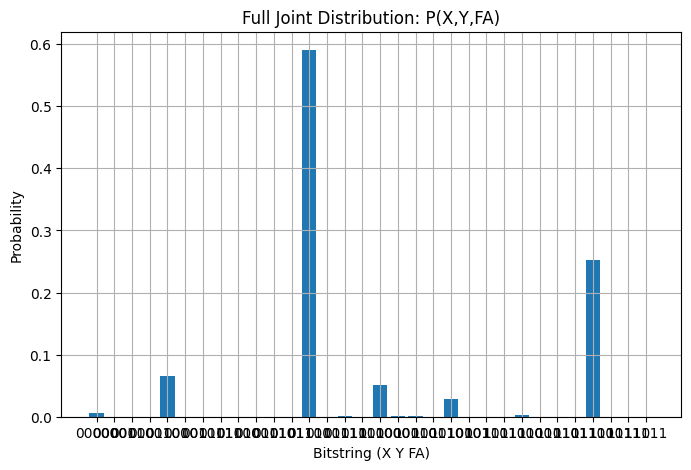

In [ ]:
import matplotlib.pyplot as plt

labels = list(probs_clean.keys())
values = list(probs_clean.values())

plt.figure(figsize=(8, 5))
plt.bar(labels, values)
plt.title("Full Joint Distribution: P(X,Y,FA)")
plt.xlabel("Bitstring (X Y FA)")
plt.ylabel("Probability")
plt.grid(True)
plt.show()


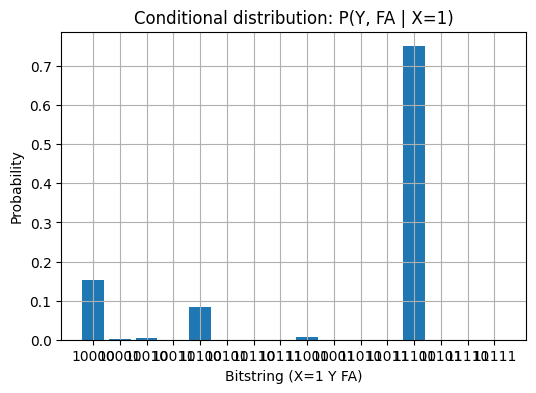

In [ ]:
filtered = {k: v for k, v in probs_clean.items() if k[0] == '1'}
norm = sum(filtered.values())
cond = {k: v / norm for k, v in filtered.items()}

plt.figure(figsize=(6, 4))
plt.bar(cond.keys(), cond.values())
plt.title("Conditional distribution: P(Y, FA | X=1)")
plt.xlabel("Bitstring (X=1 Y FA)")
plt.ylabel("Probability")
plt.grid(True)
plt.show()


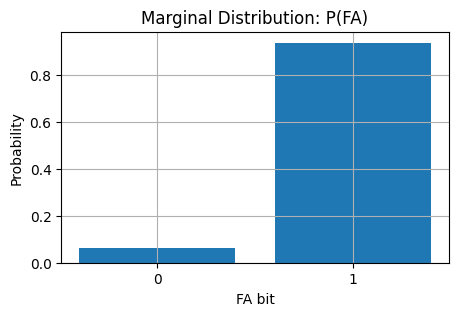

In [ ]:
p_fa = {'0': 0.0, '1': 0.0}
for k, v in probs_clean.items():
    fa_bit = k[2]
    p_fa[fa_bit] += v

plt.figure(figsize=(5, 3))
plt.bar(p_fa.keys(), p_fa.values())
plt.title("Marginal Distribution: P(FA)")
plt.xlabel("FA bit")
plt.ylabel("Probability")
plt.grid(True)
plt.show()


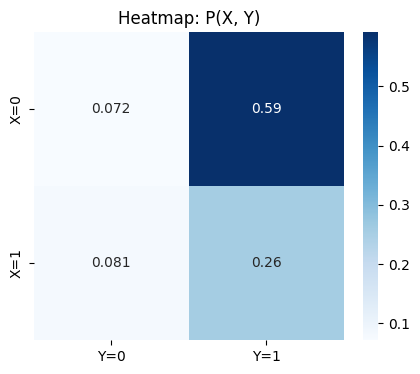

In [ ]:
import seaborn as sns
import numpy as np

joint_xy = {'00': 0, '01': 0, '10': 0, '11': 0}
for k, v in probs_clean.items():
    joint_xy[k[0] + k[1]] += v

xy_matrix = np.array([
    [joint_xy['00'], joint_xy['01']],
    [joint_xy['10'], joint_xy['11']]
])
plt.figure(figsize=(5, 4))
sns.heatmap(xy_matrix, annot=True, cmap="Blues", xticklabels=['Y=0', 'Y=1'], yticklabels=['X=0', 'X=1'])
plt.title("Heatmap: P(X, Y)")
plt.show()


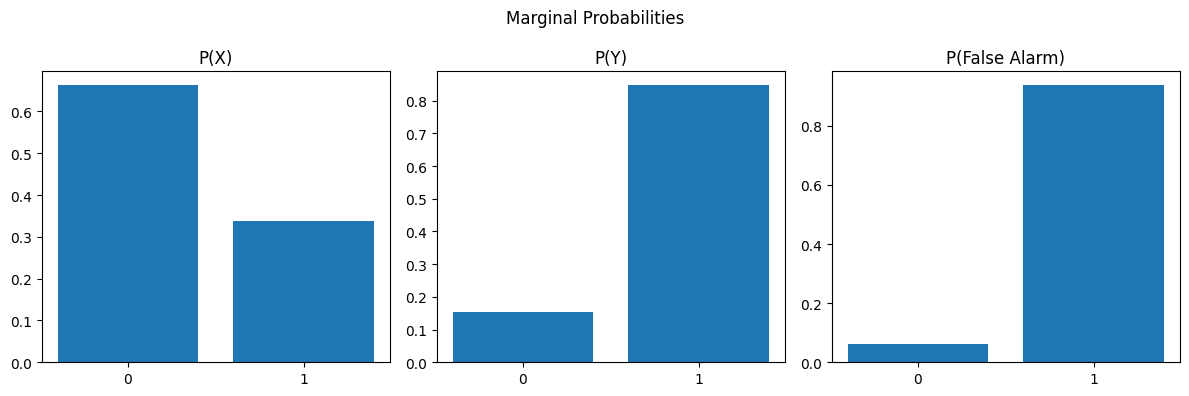

In [ ]:
# Marginals
p_x = {'0': 0.0, '1': 0.0}
p_y = {'0': 0.0, '1': 0.0}
p_fa = {'0': 0.0, '1': 0.0}

for k, v in probs_clean.items():
    p_x[k[0]] += v
    p_y[k[1]] += v
    p_fa[k[2]] += v

# Plot Marginals
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].bar(p_x.keys(), p_x.values())
axs[0].set_title('P(X)')
axs[1].bar(p_y.keys(), p_y.values())
axs[1].set_title('P(Y)')
axs[2].bar(p_fa.keys(), p_fa.values())
axs[2].set_title('P(False Alarm)')
plt.suptitle("Marginal Probabilities")
plt.tight_layout()
plt.show()


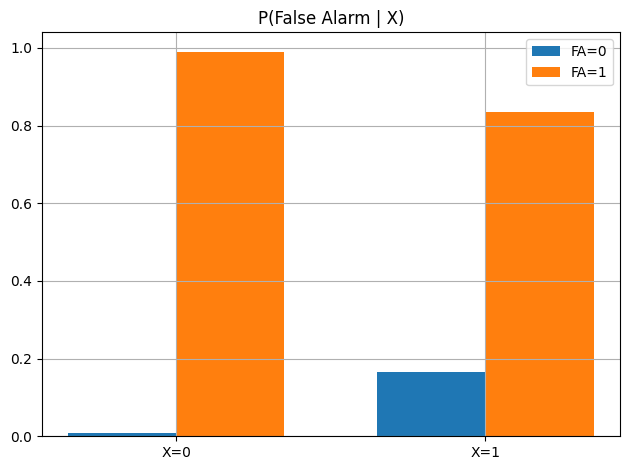

In [ ]:
# P(FA | X)
p_fa_given_x = {'X=0': {'0': 0, '1': 0}, 'X=1': {'0': 0, '1': 0}}
for k, v in probs_clean.items():
    label = 'X=' + k[0]
    p_fa_given_x[label][k[2]] += v

# Normalize
for k in p_fa_given_x:
    total = sum(p_fa_given_x[k].values())
    for f in p_fa_given_x[k]:
        p_fa_given_x[k][f] /= total

# Plot
fig, ax = plt.subplots()
labels = list(p_fa_given_x.keys())
x0 = [p_fa_given_x[k]['0'] for k in labels]
x1 = [p_fa_given_x[k]['1'] for k in labels]
bar_width = 0.35
x = np.arange(len(labels))

ax.bar(x, x0, width=bar_width, label='FA=0')
ax.bar(x + bar_width, x1, width=bar_width, label='FA=1')
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(labels)
ax.set_title('P(False Alarm | X)')
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


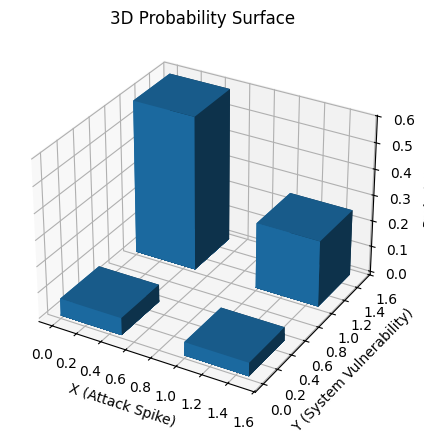

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection='3d')

bitstrings = list(probs_clean.keys())
x_pos = [int(b[0]) for b in bitstrings]
y_pos = [int(b[1]) for b in bitstrings]
z_pos = [0] * len(bitstrings)
dx = dy = [0.5] * len(bitstrings)
dz = [probs_clean[b] for b in bitstrings]

ax.bar3d(x_pos, y_pos, z_pos, dx, dy, dz)
ax.set_xlabel('X (Attack Spike)')
ax.set_ylabel('Y (System Vulnerability)')
ax.set_zlabel('Probability')
ax.set_title('3D Probability Surface')
plt.show()


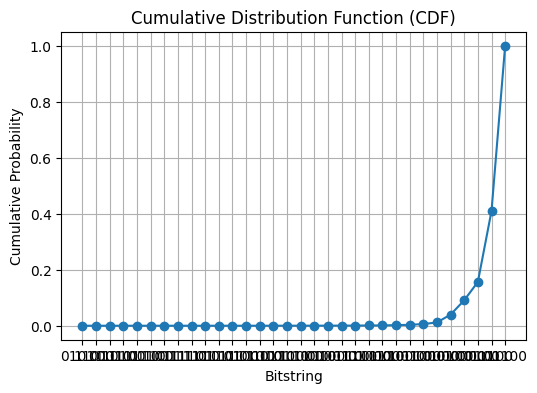

In [ ]:
sorted_probs = sorted(probs_clean.items(), key=lambda x: x[1])
labels, values = zip(*sorted_probs)
cdf = np.cumsum(values)

plt.figure(figsize=(6, 4))
plt.plot(labels, cdf, marker='o')
plt.title("Cumulative Distribution Function (CDF)")
plt.xlabel("Bitstring")
plt.ylabel("Cumulative Probability")
plt.grid(True)
plt.show()


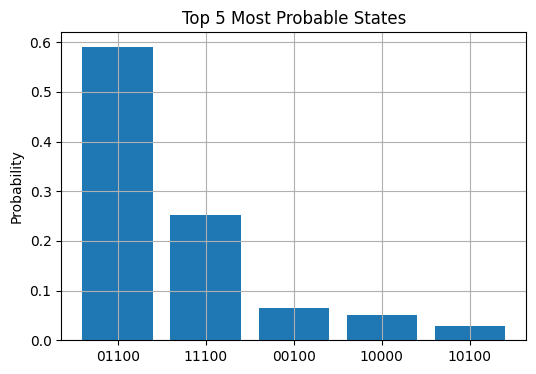

In [ ]:
top_probs = dict(sorted(probs_clean.items(), key=lambda x: x[1], reverse=True)[:5])
plt.figure(figsize=(6, 4))
plt.bar(top_probs.keys(), top_probs.values())
plt.title("Top 5 Most Probable States")
plt.ylabel("Probability")
plt.grid(True)
plt.show()
